# TUTORIAL: pynu_coinc_findtrigs

The main goal with pynu_coinc_findtrigs is to find triggers in gravitational wave data that are coincident across all detectors, and that may originate from the same sky location.  To do this, we consider that gravitational waves take time to reach different detectors on Earth.

<img src="https://media2.giphy.com/media/l4KhUjhoO6RC4UHhS/giphy.gif"  width="60%">

The time difference that there may be between two triggers is what I'll refer to as the *time delay* or $dt$. It depends both on the direction from which the signal is coming from in the sky (right ascension, delination) and the time at which it arrives on Earth. This appears in the data as a delay between triggers. For example, if a gravitational wave arrives from a direction such that it is detected at LIGO Hanford first and then at LIGO Livingston, the data may look like this:

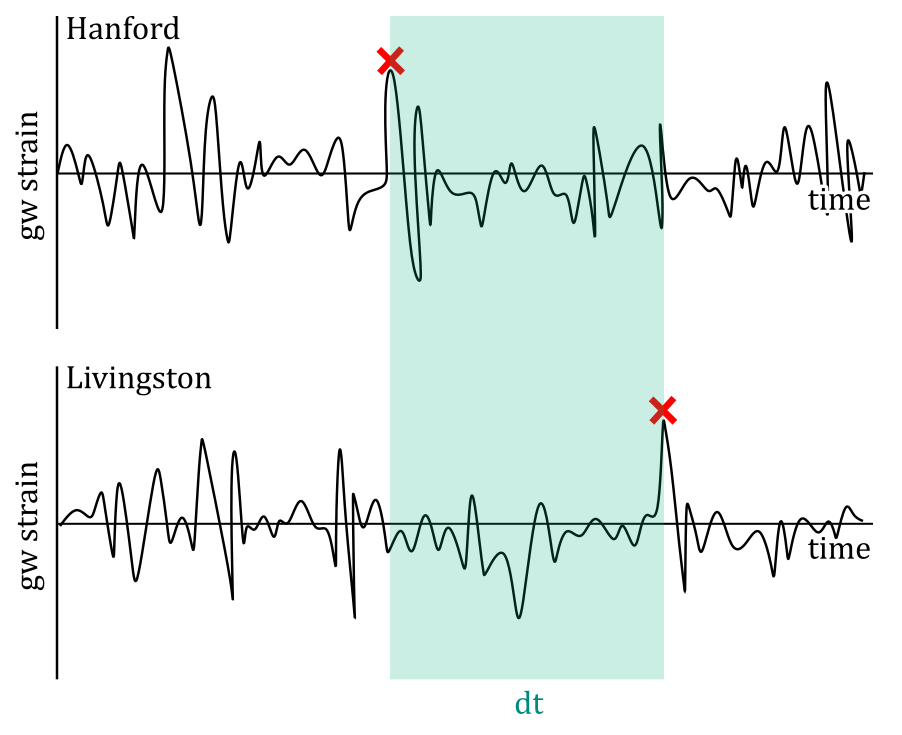

An all-sky search looks through all possible time delays. Our goal is to redefine "coincident triggers" as triggers that have the correct time delay between each detector, given a specific sky location and trigger time.

## How to use it

PyNu works similarly to PyCBC. If you want to simply use it in the command line, here is a full example on how to install and use it. The details of how the code works can be found after this example.

### Create the environment
You can create the PyNu environment in the same way as you would [install PyCBC](https://pycbc.org/pycbc/latest/html/install.html), but cloning my fork with the PyNu changes. First, create your virtual environment:
```
virtualenv -p python3 env
source env/bin/activate
pip install --upgrade pip setuptools
```
and then clone my specific branch/repository:

```
git clone --branch coinc-by-time-delay https://github.com/viviana-caceres/pycbc.git
```
Finally, install the development environment packages:
```
cd pycbc
pip install -r requirements.txt
pip install -r companion.txt
pip install .
```

### Acquire your data
The files I use for this example are found [here](https://ldas-jobs.ligo.caltech.edu/~viviana.caceres/PYNU/coinc_findtrigs/) (LIGO login required), which you can copy to your directory. These contain the data around GW170817. In general, you will need:
*   Statistic files
*   Template bank
*   Trigger files
*   Veto files

and, of course, the sky location and GPS time of the trigger you are looking for.


### Run pynu_coinc_findtrigs

You can specify the right ascension, declination, and trigger time (GPS) in the command line as such:

```
--ra 3.439 \
--dec -0.408 \
--trigger-time 1187008882 \
```

Note: The trigger time must be an integer.

You can specify an "error window" $\epsilon$ that allows you to look for trigger with a time delay of $dt \pm \epsilon$ as such:
```
--coinc-threshold 0.001
```
Note: coinc-threshold in PyCBC means something different than what it means in PyNu (this is explained better in following sections).

The rest of the arguments are used in the same way in PyCBC and PyNu. A full command would look something like this:





```
pynu_coinc_findtrigs \
  --ra 3.439 \
  --dec -0.408 \
  --trigger-time 1187008882 \
  --statistic-files H1L1-PHASE_TIME_AMP_O3.hdf H1V1-PHASE_TIME_AMP_O3.hdf L1V1-PHASE_TIME_AMP_O3.hdf \
  --coinc-threshold 0.001 \
  --sngl-ranking newsnr_sgveto_psdvar_threshold \
  --ranking-statistic phasetd_exp_fit_fgbg_norm \
  --randomize-template-order --statistic-keywords max_chirp_mass:40 \
  --gating-veto-windows H1:-1,2.5 L1:-1,2.5 \
  --timeslide-interval 2.0 \
  --loudest-keep-values 15:5,10:30,5:30,0:30 \
  --template-bank H1L1-BANK2HDF-1186993882-30000.hdf \
  --trigger-files H1-HDF_TRIGGER_MERGE_FULL_DATA-1186993882-30000.hdf L1-HDF_TRIGGER_MERGE_FULL_DATA-1186993882-30000.hdf \
  --statistic-files  H1-FIT_OVER_PARAM_FULL_DATA-1186993882-30000.hdf L1-FIT_OVER_PARAM_FULL_DATA-1186993882-30000.hdf \
  --veto-files H1L1-VETOES-1186993882-30000.xml \
  --segment-name vetoes \
  --pivot-ifo H1 \
  --fixed-ifo L1 \
  --template-fraction-range 25/60 \
  --output-file H1L1_coinc_triggers.hdf
```



This will output an HDF file with the following keys:
```
['H1', 'L1', 'decimation_factor', 'segments', 'stat', 'template_id', 'timeslide_id']
```


You may want to compare how the amount of triggers found by PyNu compares to that found by PyCBC. If we run PyCBC as normal (note that I have removed the sky location and trigger time, and set the coinc-threshold to 0):


```
pycbc_coinc_findtrigs \
  --statistic-files H1L1-PHASE_TIME_AMP_O3.hdf H1L1V1-PHASE_TIME_AMP_O3.hdf H1V1-PHASE_TIME_AMP_O3.hdf L1V1-PHASE_TIME_AMP_O3.hdf \
  --coinc-threshold 0.0 \
  --sngl-ranking newsnr_sgveto_psdvar_threshold \
  --ranking-statistic phasetd_exp_fit_fgbg_norm \
  --randomize-template-order --statistic-keywords max_chirp_mass:40 \
  --gating-veto-windows H1:-1,2.5 L1:-1,2.5 \
  --timeslide-interval 2.0 \
  --loudest-keep-values 15:5,10:30,5:30,0:30 \
  --template-bank H1L1-BANK2HDF-1168861818-30000.hdf \
  --trigger-files L1-HDF_TRIGGER_MERGE_FULL_DATA-1168861818-30000.hdf H1-HDF_TRIGGER_MERGE_FULL_DATA-1168861818-30000.hdf \
  --statistic-files H1-FIT_OVER_PARAM_FULL_DATA-1168861818-30000.hdf L1-FIT_OVER_PARAM_FULL_DATA-1168861818-30000.hdf \
  --veto-files H1L1-VETOES-1168861818-30000.xml \
  --segment-name vetoes \
  --pivot-ifo H1 \
  --fixed-ifo L1 \
  --template-fraction-range 25/60 \
  --output-file H1L1_coinc_triggers_pycbc.hdf
```
then we obtain the following trigger time series for PyNu and PyCBC.


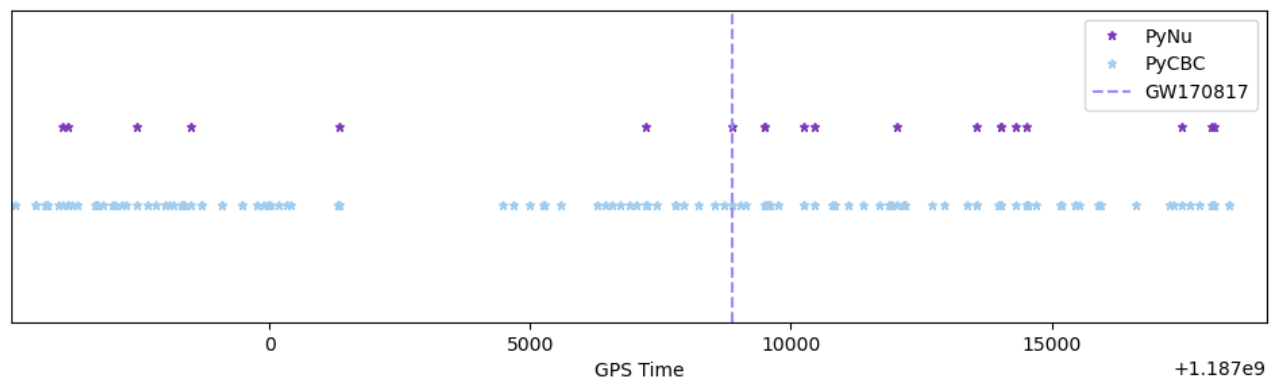

## How it works

As mentioned, [pynu_coinc_findtrigs](https://github.com/viviana-caceres/pycbc/blob/coinc-by-time-delay/bin/pynu/pynu_coinc_findtrigs) is very similar to [pycbc_coinc_findtrigs](https://github.com/gwastro/pycbc/blob/master/bin/all_sky_search/pycbc_coinc_findtrigs). I will not go over everything each one does. I will just discuss the changes I made to PyCBC's version.

The first and most obvious is that pynu_coinc_findtrigs requires a sky location and trigger time. These are added to the command line options in [line 40](https://github.com/viviana-caceres/pycbc/blob/coinc-by-time-delay/bin/pynu/pynu_coinc_findtrigs#L40).
```
# Sky location and time delay options
parser.add_argument("--ra", type=float,
                    help="Right ascension of external trigger, in radians")
parser.add_argument("--dec", type=float,
                    help="Declination of external trigger, in radians")
parser.add_argument("--trigger-time", type=int,
                    help="Time of the external trigger, used to find the"
                         " time delay between detectors.")
```

This information is the stored in a dictionary in [line 91](https://github.com/viviana-caceres/pycbc/blob/coinc-by-time-delay/bin/pynu/pynu_coinc_findtrigs#L91).
```
# Store sky location information in a dictionary
skyloc = {'t_gps': args.trigger_time,
          'ra': args.ra,
          'dec': args.dec}
```
